In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kesavamruthalakshmi","key":"23637c819de3edc6c8b9deeffbd3dec2"}'}

In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv 'kaggle (1).json' /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d shafintamim/tomatoleaf


Dataset URL: https://www.kaggle.com/datasets/shafintamim/tomatoleaf
License(s): unknown


In [ ]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!mkdir -p ~/.kaggle
!cp kaggle\ \(1\).json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
api = KaggleApi()
api.authenticate()
dataset_name = 'shafintamim/tomatoleaf'
api.dataset_download_files(dataset_name, path='.', unzip=True)
os.listdir('.')


cp: cannot stat 'kaggle (1).json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shafintamim/tomatoleaf


['.config', 'tomatoleaf.zip', 'sample_data']

In [ ]:
import zipfile
import os
zip_path = "/content/tomatoleaf.zip"
extract_path = "/content/tomatoleaf"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)os.listdir(extract_path)


['Early_blight',
 'Yellow_Leaf_Curl_Virus',
 'Late_blight',
 'Leaf_Miner',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Mosaic_virus']

In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
root_dir = "/content/tomatoleaf"
train_dir = "/content/train"
val_dir = "/content/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = os.listdir(root_dir)
for class_name in classes:
    class_path = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data = ImageFolder(train_dir, transform=transform)
val_data = ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TomatoLeafCNN(nn.Module):
    def __init__(self):
        super(TomatoLeafCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self._to_linear = None
        self._get_flattened_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 7)

    def _get_flattened_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(-1).shape[0]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth ")


Model saved as model.pth 


In [ ]:
import time
import torch.nn.functional as F
num_epochs = 100
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
        model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    accuracy = 100 * correct / total

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Time: {epoch_time:.2f}s")


Epoch [1/100], Train Loss: 0.0226, Val Loss: 1.3517, Accuracy: 83.99%, Time: 8.06s
Epoch [2/100], Train Loss: 0.0162, Val Loss: 1.3402, Accuracy: 85.76%, Time: 8.69s
Epoch [3/100], Train Loss: 0.0162, Val Loss: 1.1212, Accuracy: 86.05%, Time: 8.73s
Epoch [4/100], Train Loss: 0.0025, Val Loss: 1.1143, Accuracy: 87.22%, Time: 8.79s
Epoch [5/100], Train Loss: 0.0350, Val Loss: 1.5887, Accuracy: 82.38%, Time: 8.16s
Epoch [6/100], Train Loss: 0.0307, Val Loss: 1.0912, Accuracy: 85.46%, Time: 8.84s
Epoch [7/100], Train Loss: 0.0197, Val Loss: 1.4535, Accuracy: 82.23%, Time: 8.97s
Epoch [8/100], Train Loss: 0.0160, Val Loss: 1.1883, Accuracy: 85.32%, Time: 8.34s
Epoch [9/100], Train Loss: 0.0156, Val Loss: 1.0202, Accuracy: 87.81%, Time: 8.76s
Epoch [10/100], Train Loss: 0.0135, Val Loss: 0.9842, Accuracy: 86.34%, Time: 8.69s
Epoch [11/100], Train Loss: 0.0135, Val Loss: 1.0172, Accuracy: 84.29%, Time: 9.29s
Epoch [12/100], Train Loss: 0.0108, Val Loss: 1.1187, Accuracy: 85.17%, Time: 8.13s
E

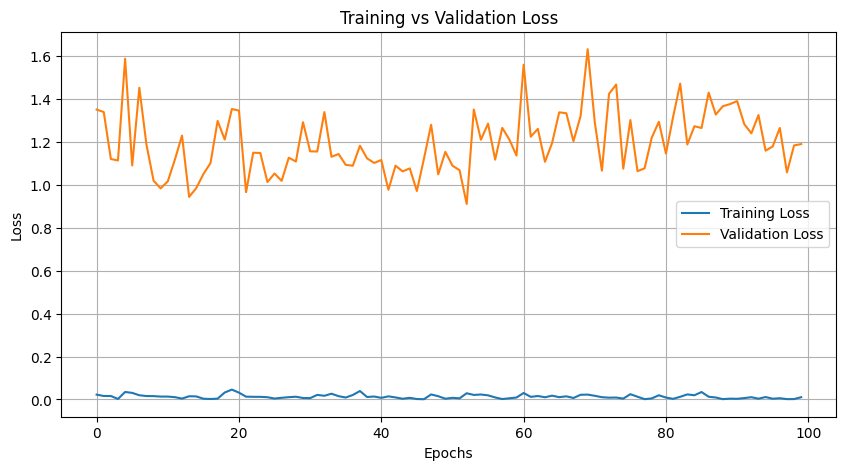

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:
import os
from sklearn.metrics import classification_report

train_dir = "/content/train"

class_names = sorted(os.listdir(train_dir))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                        precision    recall  f1-score   support

          Early_blight       0.77      0.75      0.76       100
           Late_blight       0.79      0.77      0.78       100
            Leaf_Miner       0.99      1.00      0.99        80
          Mosaic_virus       0.88      0.92      0.90       100
    Septoria_leaf_spot       0.79      0.84      0.81       100
          Spider_mites       0.90      0.86      0.88       100
Yellow_Leaf_Curl_Virus       0.94      0.91      0.92       101

              accuracy                           0.86       681
             macro avg       0.86      0.86      0.86       681
          weighted avg       0.86      0.86      0.86       681



In [ ]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                        precision    recall  f1-score   support

          Early_blight       0.77      0.75      0.76       100
           Late_blight       0.79      0.77      0.78       100
            Leaf_Miner       0.99      1.00      0.99        80
          Mosaic_virus       0.88      0.92      0.90       100
    Septoria_leaf_spot       0.79      0.84      0.81       100
          Spider_mites       0.90      0.86      0.88       100
Yellow_Leaf_Curl_Virus       0.94      0.91      0.92       101

              accuracy                           0.86       681
             macro avg       0.86      0.86      0.86       681
          weighted avg       0.86      0.86      0.86       681



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving healthytomato.jpg to healthytomato.jpg


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os

class TomatoDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(TomatoDiseaseCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "/content/train"
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

model = TomatoDiseaseCNN(num_classes)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_path = "healthytomato.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"Predicted class: {predicted_class}")



Predicted class: Late_blight


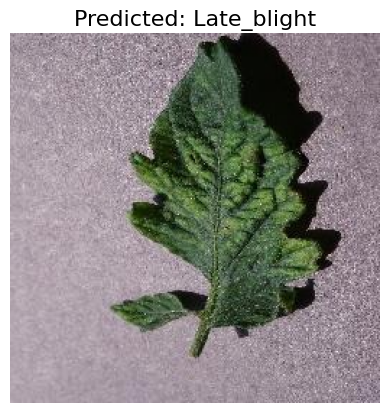

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}", fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
actual_class = "Late_blight"
print(f"Actual: {actual_class}")
print(f"Predicted: {predicted_class}")

if actual_class == predicted_class:
    print("Correct Prediction!")
else:
    print(" Wrong Prediction.")


Actual: Late_blight
Predicted: Late_blight
Correct Prediction!
